<a href="https://colab.research.google.com/github/martin-fabbri/colab-notebooks/blob/master/Frequentist_Regression_With_TFP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Imports and Global Variables (run this cell first)  { display-mode: "form" }
"""
The book uses a custom matplotlibrc file, which provides the unique styles for
matplotlib plots. If executing this book, and you wish to use the book's
styling, provided are two options:
    1. Overwrite your own matplotlibrc file with the rc-file provided in the
       book's styles/ dir. See http://matplotlib.org/users/customizing.html
    2. Also in the styles is  bmh_matplotlibrc.json file. This can be used to
       update the styles in only this notebook. Try running the following code:

        import json
        s = json.load(open("../styles/bmh_matplotlibrc.json"))
        matplotlib.rcParams.update(s)
"""
!pip3 install -q wget
from __future__ import absolute_import, division, print_function
#@markdown This sets the warning status (default is `ignore`, since this notebook runs correctly)
warning_status = "ignore" #@param ["ignore", "always", "module", "once", "default", "error"]
import warnings
warnings.filterwarnings(warning_status)
with warnings.catch_warnings():
    warnings.filterwarnings(warning_status, category=DeprecationWarning)
    warnings.filterwarnings(warning_status, category=UserWarning)

import numpy as np
import os
#@markdown This sets the styles of the plotting (default is styled like plots from [FiveThirtyeight.com](https://fivethirtyeight.com/))
matplotlib_style = 'fivethirtyeight' #@param ['fivethirtyeight', 'bmh', 'ggplot', 'seaborn', 'default', 'Solarize_Light2', 'classic', 'dark_background', 'seaborn-colorblind', 'seaborn-notebook']
import matplotlib.pyplot as plt; plt.style.use(matplotlib_style)
import matplotlib.axes as axes;
from matplotlib.patches import Ellipse
%matplotlib inline
import seaborn as sns; sns.set_context('notebook')
from IPython.core.pylabtools import figsize
#@markdown This sets the resolution of the plot outputs (`retina` is the highest resolution)
notebook_screen_res = 'retina' #@param ['retina', 'png', 'jpeg', 'svg', 'pdf']
%config InlineBackend.figure_format = notebook_screen_res

import tensorflow as tf
tfe = tf.contrib.eager

# Eager Execution
#@markdown Check the box below if you want to use [Eager Execution](https://www.tensorflow.org/guide/eager)
#@markdown Eager execution provides An intuitive interface, Easier debugging, and a control flow comparable to Numpy. You can read more about it on the [Google AI Blog](https://ai.googleblog.com/2017/10/eager-execution-imperative-define-by.html)
use_tf_eager = False #@param {type:"boolean"}

# Use try/except so we can easily re-execute the whole notebook.
if use_tf_eager:
    try:
        tf.enable_eager_execution()
    except:
        pass

import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

  
def evaluate(tensors):
    """Evaluates Tensor or EagerTensor to Numpy `ndarray`s.
    Args:
    tensors: Object of `Tensor` or EagerTensor`s; can be `list`, `tuple`,
        `namedtuple` or combinations thereof.

    Returns:
        ndarrays: Object with same structure as `tensors` except with `Tensor` or
          `EagerTensor`s replaced by Numpy `ndarray`s.
    """
    if tf.executing_eagerly():
        return tf.contrib.framework.nest.pack_sequence_as(
            tensors,
            [t.numpy() if tf.contrib.framework.is_tensor(t) else t
             for t in tf.contrib.framework.nest.flatten(tensors)])
    return sess.run(tensors)

class _TFColor(object):
    """Enum of colors used in TF docs."""
    red = '#F15854'
    blue = '#5DA5DA'
    orange = '#FAA43A'
    green = '#60BD68'
    pink = '#F17CB0'
    brown = '#B2912F'
    purple = '#B276B2'
    yellow = '#DECF3F'
    gray = '#4D4D4D'
    def __getitem__(self, i):
        return [
            self.red,
            self.orange,
            self.green,
            self.blue,
            self.pink,
            self.brown,
            self.purple,
            self.yellow,
            self.gray,
        ][i % 9]
TFColor = _TFColor()

def session_options(enable_gpu_ram_resizing=True, enable_xla=True):
    """
    Allowing the notebook to make use of GPUs if they're available.
    
    XLA (Accelerated Linear Algebra) is a domain-specific compiler for linear 
    algebra that optimizes TensorFlow computations.
    """
    config = tf.ConfigProto()
    config.log_device_placement = True
    if enable_gpu_ram_resizing:
        # `allow_growth=True` makes it possible to connect multiple colabs to your
        # GPU. Otherwise the colab malloc's all GPU ram.
        config.gpu_options.allow_growth = True
    if enable_xla:
        # Enable on XLA. https://www.tensorflow.org/performance/xla/.
        config.graph_options.optimizer_options.global_jit_level = (
            tf.OptimizerOptions.ON_1)
    return config


def reset_sess(config=None):
    """
    Convenience function to create the TF graph & session or reset them.
    """
    if config is None:
        config = session_options()
    global sess
    tf.reset_default_graph()
    try:
        sess.close()
    except:
        pass
    sess = tf.InteractiveSession(config=config)

reset_sess()

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



# Frequentist or Standard Linear Regression: The Market Model

---


An asset's Market Model (MM) is a standard time series regression of the the realized excess returns of the asset against the realized excess returns of the market. Excess returns are defined as returns in excess of some benchmark such as the risk-free rate. Model is formulated as:


**(R - F) = 𝛂 + 𝛃 (M - F) + 𝛔**

Y = (R - F) is the outcome variable,  X = (M - F) is the predictor variable, R is the realized return of a stock, F is the return on a risk-free asset (US treasury bill) , M is the realized return of a market portfolio (S&P 500), 𝛼 (alpha) is the expected stock-specific return, 𝛽 (beta) is the level of systematic risk exposure to the market, 𝛔 (sigma) is the unexpected stock-specific return



Note that an asset's MM is different from its Capital Asset Pricing Model (CAPM). Unlike the CAPM, an asset's MM has both an idiosyncratic risk term 𝛼 and an error term 𝛔 in its formulation. However, the systematic risk term beta of the asset is the same as the one calculated using the CAPM. The expected value of 𝛔 is zero. That is the reason it does not appear in the CAPM which formulates expected returns.

According to the CAPM which subscribes to the efficient market hypothesis, the intercept, or 𝛼, of an asset's MM has an expected value of zero. The asset's realized positive/(negative) 𝛼 shows that the market participants under priced/(overpriced) the security during the holding period.


# Import your data

We use the following free data sources to get the daily closing prices of various assets:

Risk free rate: https://fred.stlouisfed.org/series/TB4WK

Stock and market data: https://finance.yahoo.com

In [2]:
import statsmodels.api as sm
import pandas_datareader.data as pdr
import fix_yahoo_finance as yf
yf.pdr_override()
import matplotlib.pyplot as plt
plt.style.use('seaborn')
from datetime import datetime



start = datetime(2018, 9, 13)
end = datetime(2019, 9, 13)

riskfree_rate = pdr.DataReader('TB4WK', 'fred', start, end)
market = pdr.get_data_yahoo('SPY', start, end)
stock = pdr.get_data_yahoo('AAPL', start, end)

[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded


# Explore your data

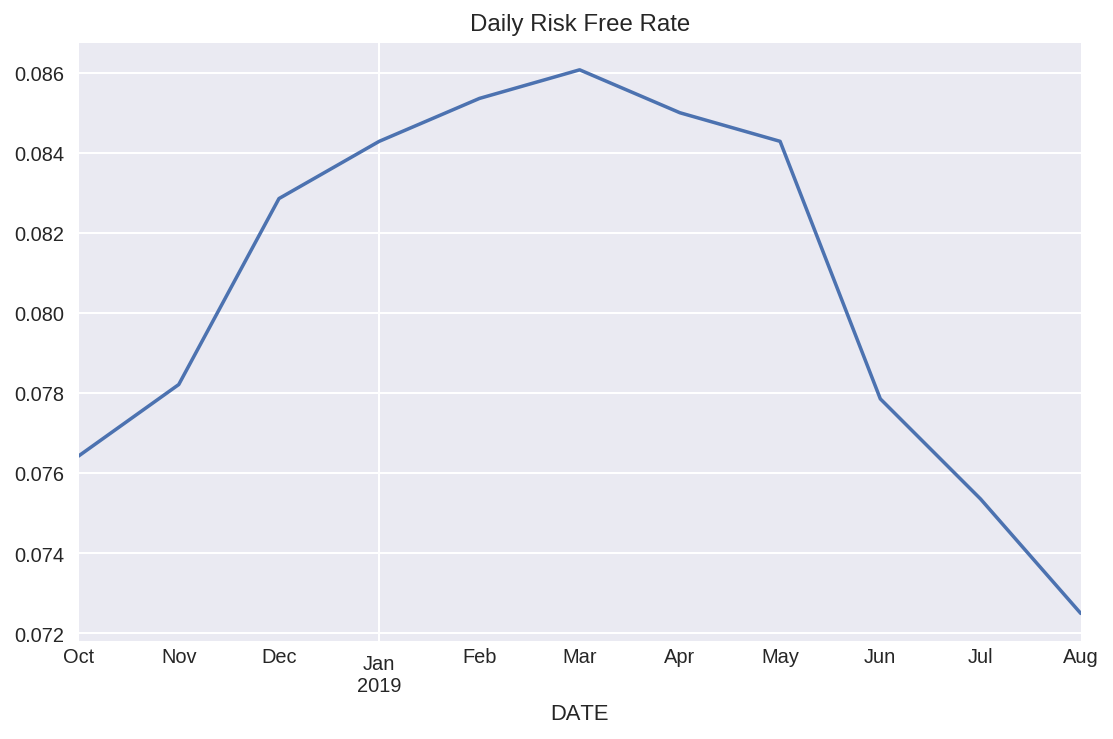

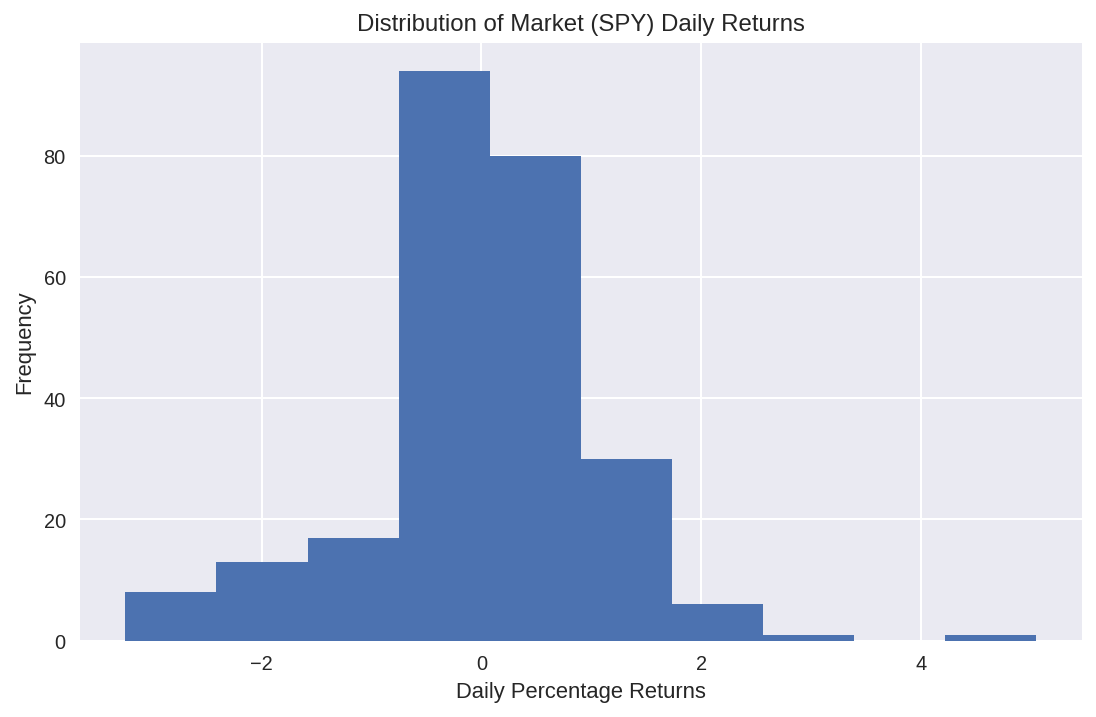

Descriptive Stastics of the Market's daily percentage returns:
count    250.000000
mean       0.027516
std        1.054556
min       -3.240233
25%       -0.385208
50%        0.050687
75%        0.623282
max        5.052480
Name: Adj Close, dtype: float64


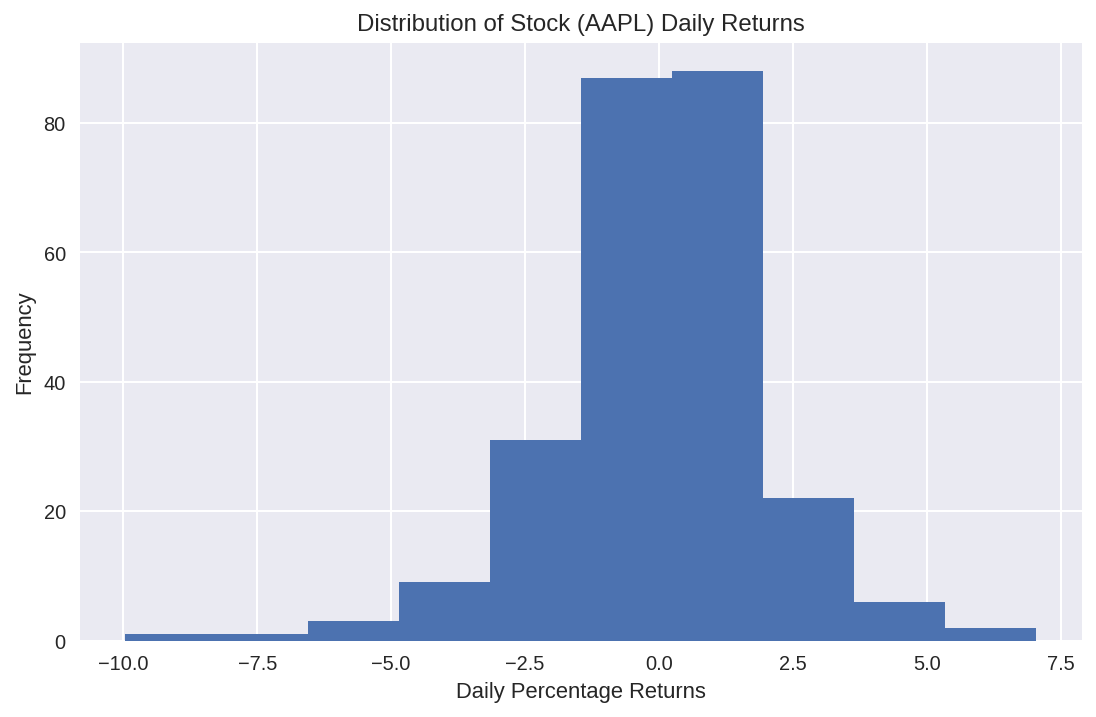

Descriptive stastics of Apple stock's percentage returns:
count    250.000000
mean       0.020877
std        2.026331
min       -9.960742
25%       -0.910270
50%        0.115801
75%        1.115335
max        7.042150
Name: Adj Close, dtype: float64


In [4]:

riskfree_rate = pdr.DataReader('TB4WK', 'fred', start, end)
riskfree_scaling = 28 #Need to scale the risk free rate by its maturity to get the daily risk free rate
riskfree_rate = riskfree_rate['TB4WK'].dropna()/riskfree_scaling
riskfree_rate.plot(), plt.title('Daily Risk Free Rate'), plt.show()


market_return = market['Adj Close'].pct_change(1)*100
market_return = market_return.dropna()
plt.hist(market_return), plt.title('Distribution of Market (SPY) Daily Returns'), plt.xlabel('Daily Percentage Returns'), plt.ylabel('Frequency'), plt.show()
print("Descriptive Stastics of the Market's daily percentage returns:\n{}".format(market_return.describe()))

stock_return = stock['Adj Close'].pct_change(1)*100
stock_return = stock_return.dropna()
plt.hist(stock_return), plt.title('Distribution of Stock (AAPL) Daily Returns'), plt.xlabel('Daily Percentage Returns'), plt.ylabel('Frequency'), plt.show()
print("Descriptive stastics of Apple stock's percentage returns:\n{}".format(stock_return.describe()))

# Build your linear regression model

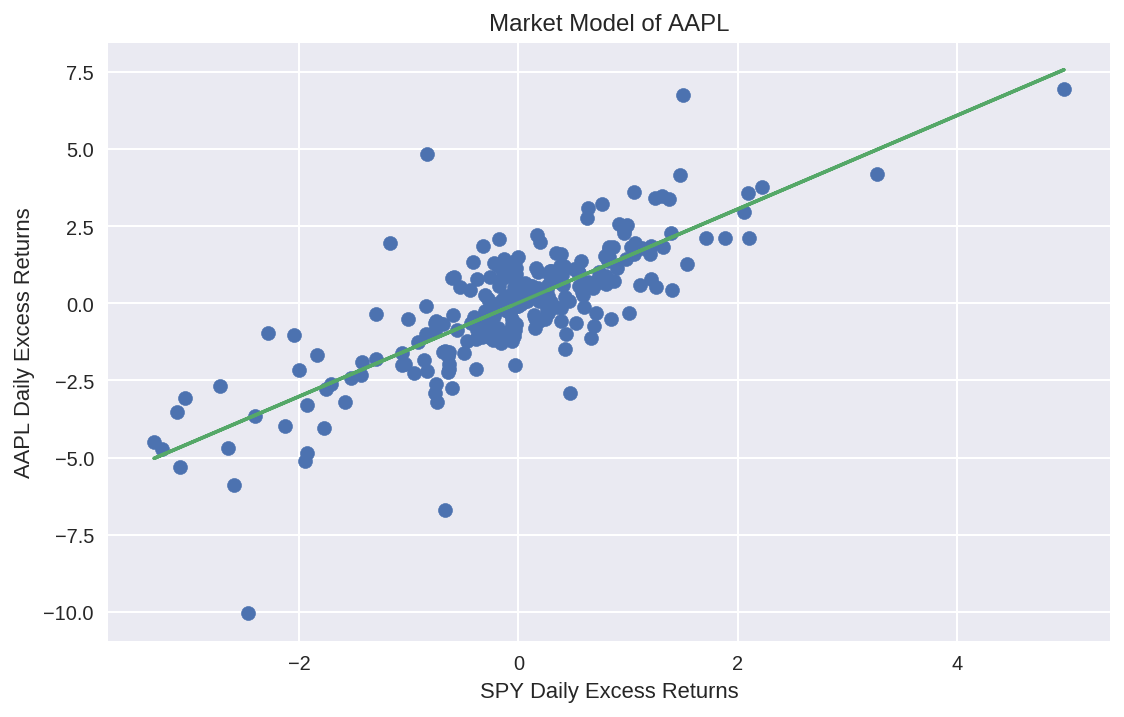

In [5]:
#AAPL's Market Model
y = stock_return - riskfree_rate.mean()
x = market_return - riskfree_rate.mean()
plt.scatter(x,y)
x = sm.add_constant(x)
market_model = sm.OLS(y, x).fit()
plt.plot(x, x*market_model.params[1]+market_model.params[0])
plt.title('Market Model of AAPL'), plt.xlabel('SPY Daily Excess Returns'), plt.ylabel('AAPL Daily Excess Returns'), plt.show();

# Analyze your results

In [6]:
print("According to AAPL's Market Model, the security had a realized Alpha of {0}% and Beta of {1}%".format(round(market_model.params[0],2), round(market_model.params[1],2)))
print("The Market Model of AAPL is summarized below:\n{}".format(market_model.summary()));

According to AAPL's Market Model, the security had a realized Alpha of 0.02% and Beta of 1.52%
The Market Model of AAPL is summarized below:
                            OLS Regression Results                            
Dep. Variable:              Adj Close   R-squared:                       0.625
Model:                            OLS   Adj. R-squared:                  0.624
Method:                 Least Squares   F-statistic:                     413.4
Date:                Mon, 16 Sep 2019   Prob (F-statistic):           9.61e-55
Time:                        18:46:58   Log-Likelihood:                -408.18
No. Observations:                 250   AIC:                             820.4
Df Residuals:                     248   BIC:                             827.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025   

# Build your linear regression model using TensorFlow Probability

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
beta= [1.5185828]
daily average return= 0.041785184


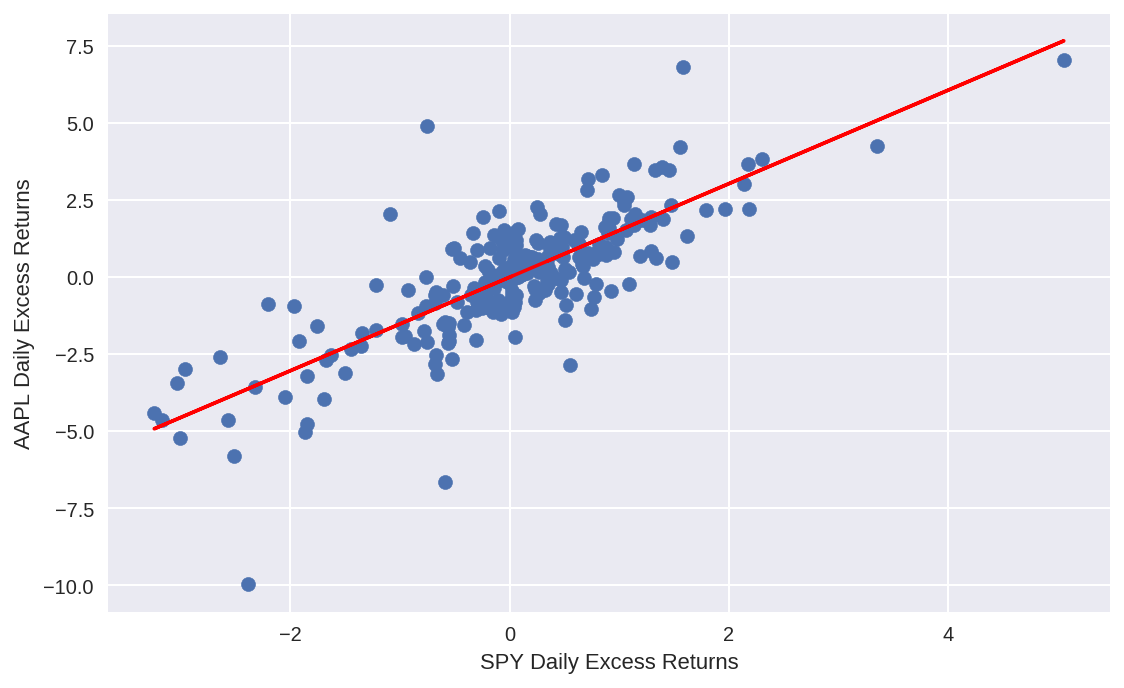

In [7]:
stock_return_vals_ = stock_return.values
stock_return_vals =  tf.convert_to_tensor(stock_return_vals_, dtype=tf.float32)
market_return_vals_ = market_return.values
market_return_vals = tf.convert_to_tensor(market_return_vals_, dtype=tf.float32)

# Specify model.
model = tfp.glm.Normal()

# Fit model given data.
coeffs, linear_response, is_converged, num_iter = tfp.glm.fit(
    model_matrix=market_return_vals[:, tf.newaxis],
    response=stock_return_vals,
    model=model)

mean_linear_response = tf.reduce_mean(linear_response)

# Execute graph
[   
    coeffs_,
    mean_linear_response_,
    linear_response_
] = evaluate (
[
    coeffs,
    mean_linear_response,
    linear_response,
])
print("beta=",coeffs_)
print("daily average return=", mean_linear_response_)
plt.scatter(market_return,stock_return) 
plt.plot(market_return_vals_,linear_response_,color='red')
plt.xlabel('SPY Daily Excess Returns'), plt.ylabel('AAPL Daily Excess Returns'), plt.show();